In [195]:
import cv2
import time
import scipy.io as sio
import skimage
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

In [196]:
landmark_points_68 = [162,234,93,58,172,136,149,148,152,377,378,365,397,288,323,454,389,71,63,105,66,107,336,
                  296,334,293,301,168,197,5,4,75,97,2,326,305,33,160,158,133,153,144,362,385,387,263,373,
                  380,61,39,37,0,267,269,291,405,314,17,84,181,78,82,13,312,308,317,14,87]

mask_name = "cat" # "cat", "santa"

### Detect the Face using Haar Cascade Classifier

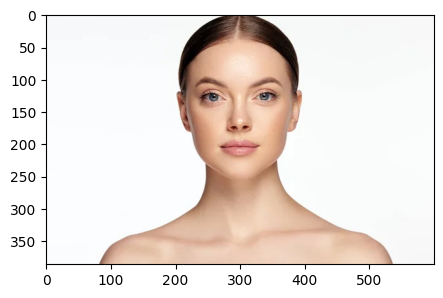

In [197]:
face = cv2.imread("../images/face.jpg")
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(face)
plt.show()

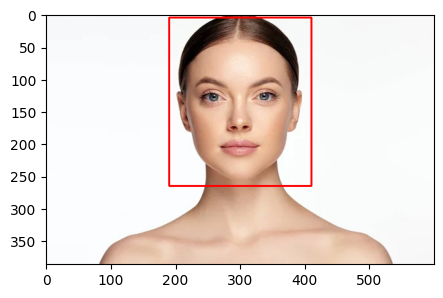

In [198]:
detector = cv2.CascadeClassifier("../data/haarcascade_frontalface_default.xml")
results = detector.detectMultiScale(face, 1.3, 5)
face_copy = np.copy(face)
for (x, y, w, h) in results:
    cv2.rectangle(face_copy, (x-10, y-40), (x+w+10, y+h+20), (255, 0, 0), 2)

plt.figure(figsize=(5, 5))
plt.imshow(face_copy)
plt.show()



### Segment the face


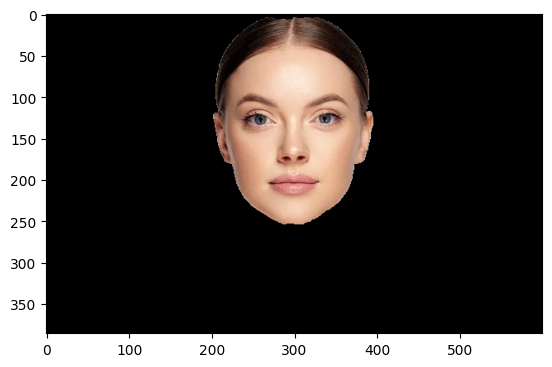

Total time taken for segmentation: 0.57 seconds


In [199]:
# segment out the face using grabcut
st = time.time()
bgModel = np.zeros((1, 65), np.float64)
fgModel = np.zeros((1, 65), np.float64)

mask = np.zeros(face.shape[:2], np.uint8)

rect = (results[0][0]-10, results[0][1]-40, results[0][2]+10, results[0][3]+60)
face_copy = np.copy(face)
cv2.grabCut(face_copy, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
face_copy = face_copy*mask2[:, :, np.newaxis]

plt.imshow(face_copy)
plt.show()

et = time.time()
print(f"Total time taken for segmentation: {et-st:.2f} seconds")

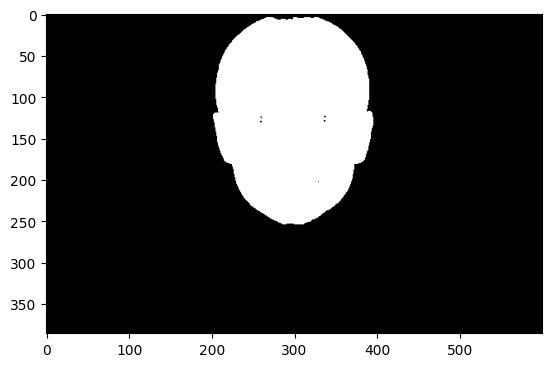

In [200]:
# display face mask
plt.imshow(mask2, cmap='gray')
plt.show()

#### Smoothen the mask using Gaussian Blurring

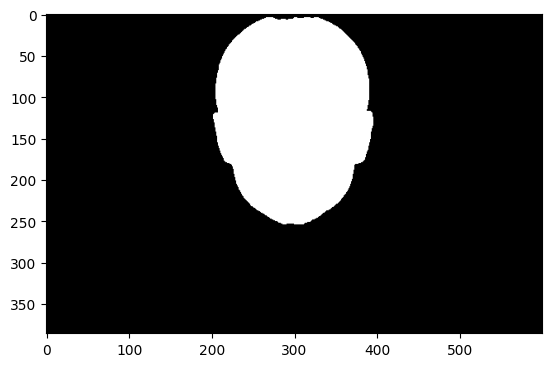

In [201]:
# smoothen the mask with a gaussian filter
mask2 = cv2.GaussianBlur(mask2, (5, 5), 0)
plt.imshow(mask2, cmap='gray')
plt.show()

### Face Landmarks


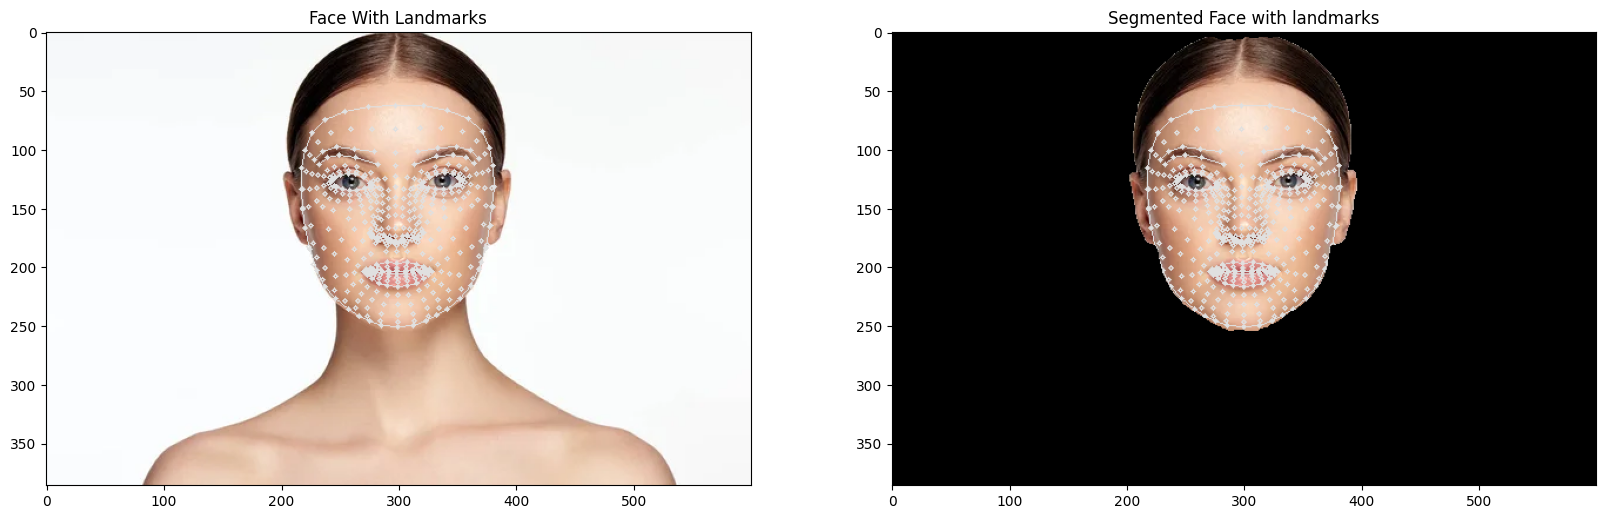

In [202]:
mpDraw = mp.solutions.drawing_utils
mpFaceMesh = mp.solutions.face_mesh
face_mesh = mpFaceMesh.FaceMesh(max_num_faces=1)
drawSpec = mpDraw.DrawingSpec(thickness=1, circle_radius=1)

face_copy = np.copy(face)
landmarks = face_mesh.process(face_copy)
if landmarks.multi_face_landmarks:
    for face_landmarks in landmarks.multi_face_landmarks:
        landmarks_extracted = []
        for index in landmark_points_68:
            x = int(face_landmarks.landmark[index].x * face.shape[1])
            y = int(face_landmarks.landmark[index].y * face.shape[0])
            landmarks_extracted.append((x, y))
        mpDraw.draw_landmarks(face_copy, face_landmarks, mpFaceMesh.FACEMESH_CONTOURS, drawSpec, drawSpec)


segmented_face = np.multiply(face_copy, mask2[:, :, np.newaxis])
plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.title("Face With Landmarks")
plt.imshow(face_copy)
plt.subplot(1,2,2)
plt.title("Segmented Face with landmarks")
plt.imshow(segmented_face)
plt.show()

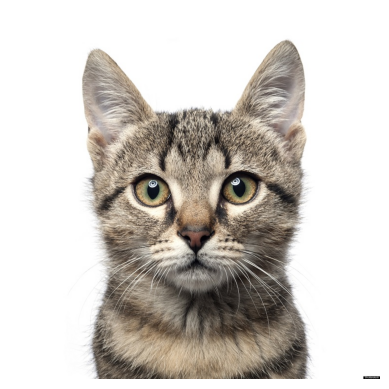

In [203]:
mat = sio.loadmat(f'../mask_files/{mask_name}.mat')

santa = mat['Imask']
face_map = mat['Imask_map']
face_map[face_map<127] = 0
face_map[face_map>=127] = 255
hat_map = mat['Imask_map_hat']
hat_map[hat_map<127] = 0
hat_map[hat_map>=127] = 255

x_coords, y_coords = mat['landmark_points_array_mask'][0][0]

santa_landmarks = []
for i in range(len(x_coords)):
    santa_landmarks.append([x_coords[i], y_coords[i]])

plt.imshow(santa)
plt.axis('off')
plt.show()

In [204]:
# for i in mat:
#     if i.startswith('Imask'):
#         continue
#     print(i, mat[i])

(['__header__', '__version__', '__globals__', 'Imask', 'Imask_map', 'Imask_map_hat', 'TempK', 'a', 'add_hat', 'add_vignetting', 'amp', 'avoid_artifacts', 'change_color_temp', 'effect', 'effect_img', 'face_mask', 'filt', 'gradient_blur', 'hat_c', 'hat_line', 'hat_w', 'landmark_points_array_mask', 'makeEyeHoles'])

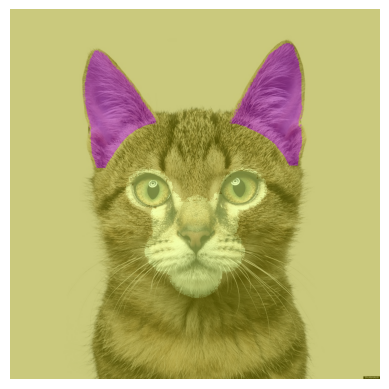

In [205]:
map1 = np.array(cv2.normalize(face_map, None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
map1 = cv2.applyColorMap(map1, cv2.COLORMAP_MAGMA)

map2 = np.array(cv2.normalize(hat_map, None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)
map2 = cv2.applyColorMap(map2, cv2.COLORMAP_COOL)

blended = cv2.addWeighted(santa, 0.7, map1, 0.3, 0)
blended = cv2.addWeighted(blended, 0.7, map2, 0.3, 0)

plt.imshow(blended)
plt.axis('off')
plt.show()

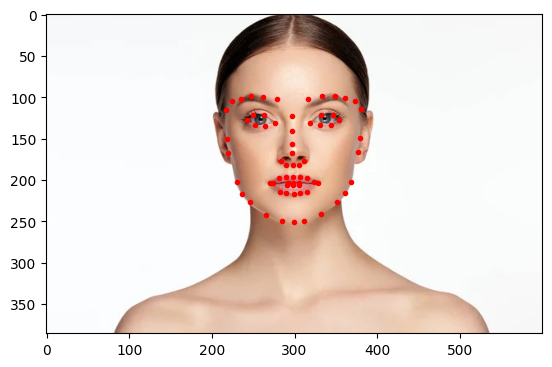

In [206]:
# plt.figure(figsize=(10, 10), dpi=500)
plt.imshow(face)

landmarks_extracted = np.array(landmarks_extracted)
plt.scatter(landmarks_extracted[:, 0], landmarks_extracted[:,1], color='red', marker='.')
# for i, (x, y) in enumerate(zip(x_coords, y_coords)):
#     plt.annotate(i+1, (x, y), color='red')

plt.show()

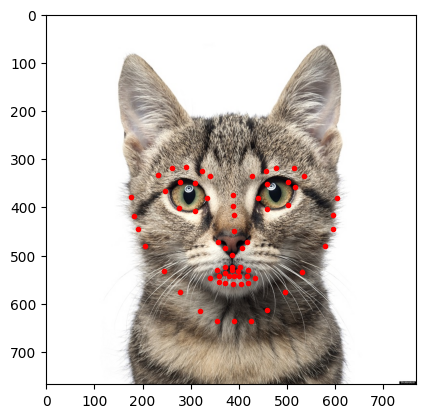

In [207]:
# plt.figure(figsize=(10, 10), dpi=500)
plt.imshow(mat['Imask'])

plt.scatter(x_coords, y_coords, color='red', marker='.')
# for i, (x, y) in enumerate(zip(x_coords, y_coords)):
#     plt.annotate(i+1, (x, y), color='red')

plt.show()

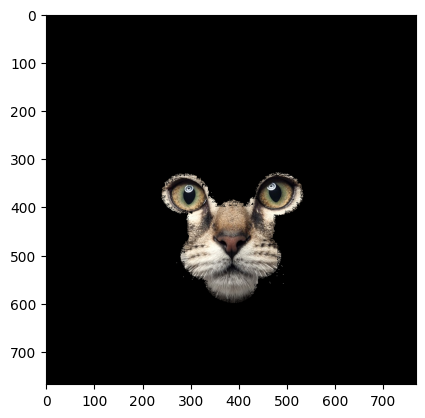

In [208]:
santa1 = np.copy(santa)
# Get the santa from the segmented mask

santa1[face_map==0] = 0
plt.imshow(santa1)
plt.show()

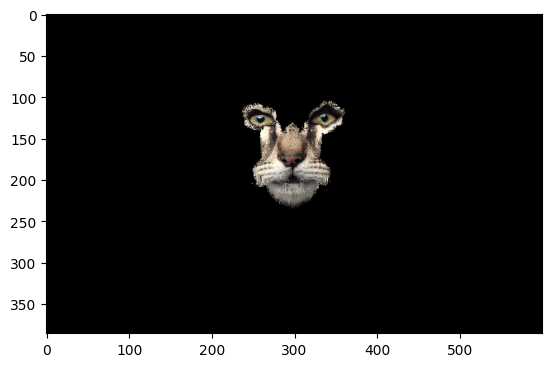

In [209]:
warp_trans = skimage.transform.PiecewiseAffineTransform()
warp_trans.estimate(landmarks_extracted, np.array(santa_landmarks))
warped = skimage.transform.warp(santa1, warp_trans, output_shape=face.shape)
warped = warped.astype(np.float32)
plt.imshow(warped)
plt.show()

In [210]:
# gray_image = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY) * 255

# edges = cv2.Canny(gray_image.astype(np.uint8), 50, 150)

# edge_mask = cv2.merge([edges, edges, edges])

# smoothed_edges = cv2.bilateralFilter(warped, d=9, sigmaColor=75, sigmaSpace=75, borderType=cv2.BORDER_CONSTANT)

# warped1 = np.where(edge_mask != 0, smoothed_edges, warped)

# plt.imshow(warped1)

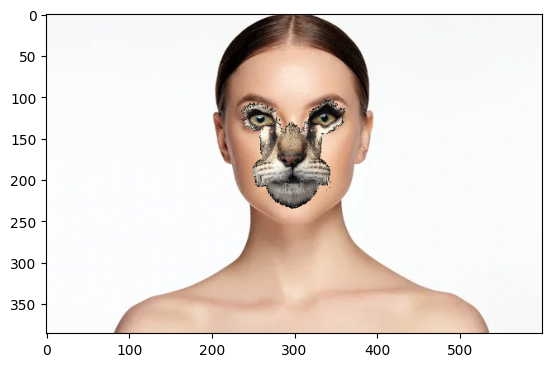

In [211]:
blended_face = face.copy().astype(np.float32) / 255.0
mask = warped > 0
blended_face[mask] = warped[mask]

plt.imshow(blended_face)